<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [99]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [100]:
# set max number of columns and rows shown to 100
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [101]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [102]:
house.shape

(1460, 81)

In [103]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [104]:
def data_overview(house, sort='Missing%'):
    list_of_numerics=house.select_dtypes(include=['float','int']).columns
    types= house.dtypes
    missing= round((house.isnull().sum()/house.shape[0]),3)*100
    overview = house.apply(lambda x: [round(x.min()), 
                                      round(x.quantile(0.5)),
                                      round(x.max()), 
                                      round(x.mean())] if x.name in list_of_numerics else x.nunique())
    outliers = house.apply(lambda x: sum(
                                     (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25))))|
                                     (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25))))
                                     if x.name in list_of_numerics else ''))
    explo = pd.DataFrame({'Types': types,
                          'Missing%': missing,
                          'Overview': overview,
                          'Outliers': outliers})
    return explo.sort_values(by=sort, ascending=False)

In [105]:
data_overview(house, sort='Missing%')

,Types,Missing%,Overview,Outliers
PoolQC,object,99.5,3,0
MiscFeature,object,96.3,4,0
Alley,object,93.8,2,0
Fence,object,80.8,4,0
FireplaceQu,object,47.3,5,0
LotFrontage,float64,17.7,"[21, 69, 313, 70.0]",88
GarageYrBlt,float64,5.5,"[1900, 1980, 2010, 1979.0]",0
GarageCond,object,5.5,5,0
GarageType,object,5.5,6,0
GarageFinish,object,5.5,3,0


In [106]:
#The following data variables have been removed as a large amount of the data is missing
#PoolQC
house.drop('PoolQC', axis=1, inplace=True)
#MiscFeature
house.drop('MiscFeature', axis=1, inplace=True)
#Alley
house.drop('Alley', axis=1, inplace=True)
#Fence
house.drop('Fence', axis=1, inplace=True)
#FireplaceQu
house.drop('FireplaceQu', axis=1, inplace=True)

In [107]:
data_overview(house, sort='Types')

,Types,Missing%,Overview,Outliers
Heating,object,0.0,6,0
BsmtFinType1,object,2.5,6,0
Exterior2nd,object,0.0,16,0
MasVnrType,object,0.5,4,0
Functional,object,0.0,7,0
ExterCond,object,0.0,5,0
Foundation,object,0.0,6,0
BsmtQual,object,2.5,4,0
BsmtCond,object,2.5,4,0
BsmtExposure,object,2.6,4,0


In [108]:
#Cleaning up the data types 

#Objects: Bsmt_Fin_Type1, Bsmt_Qual, Bsmt_Cond, Bsmt_Exposure, Bsmt_Fin_Type2, 

#Electrical, Garage_Cond, Garage_Qual, Garage_Finish, Garage_Type

#Intergers: Garage_Yr_Blt(Nan=81), Lot_Frontage (NaN=259). In order to manage this i will take the average for each residential home type and fill the NaN values 

#Removing all non residential properties from the data

In [109]:
house.BsmtQual.fillna('None', inplace=True)

In [110]:
house.BsmtFinType1.fillna('None', inplace=True)

In [111]:
house.BsmtCond.fillna('None', inplace=True)

In [112]:
house.BsmtExposure.fillna('None', inplace=True)

In [113]:
house.BsmtFinType2.fillna('None', inplace=True)

In [114]:
#Dropped as only 1 value 
house.Electrical.dropna(inplace = True)

In [115]:
house.GarageCond.fillna('None', inplace=True)

In [116]:
house.GarageQual.fillna('None', inplace=True)

In [117]:
house.GarageFinish.fillna('None', inplace=True)

In [118]:
house.GarageType.fillna('None', inplace=True)

In [119]:
house['GarageYrBlt']=house.groupby('MSZoning')['GarageYrBlt'].transform(lambda x:x.fillna(x.mean()))

In [120]:
house['LotFrontage']=house.groupby('MSZoning')['LotFrontage'].transform(lambda x:x.fillna(x.mean()))

In [121]:
house.MSZoning.value_counts(dropna=False)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [122]:
house.loc[house.MSZoning =='C (all)']

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
30,31,70,C (all),50.0,8500,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,649,GasA,TA,N,SBrkr,649,668,0,1317,0,0,1,0,3,1,TA,6,Typ,0,Detchd,1920.00,Unf,1,250,TA,Fa,N,0,54,172,0,0,0,0,7,2008,WD,Normal,40000
88,89,50,C (all),105.0,8470,Pave,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,None,1957.75,None,0,0,None,None,N,0,0,156,0,0,0,0,10,2009,ConLD,Abnorml,85000
93,94,190,C (all),60.0,7200,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,6,1910,1998,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,Fa,Mn,Rec,1046,Unf,0,168,1214,GasW,Ex,N,SBrkr,1260,1031,0,2291,0,1,2,0,4,2,TA,9,Typ,1,Detchd,1900.00,Unf,2,506,TA,TA,Y,0,0,0,0,99,0,0,11,2007,WD,Normal,133900
495,496,30,C (all),60.0,7879,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,495,Unf,0,225,720,GasA,TA,N,FuseA,720,0,0,720,0,0,1,0,2,1,TA,4,Typ,0,None,1957.75,None,0,0,None,None,N,0,523,115,0,0,0,0,11,2009,WD,Abnorml,34900
557,558,50,C (all),60.0,11040,Pave,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1.5Fin,4,6,1920,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,637,Unf,0,0,637,GasA,Gd,Y,SBrkr,897,439,0,1336,0,0,1,1,3,1,TA,7,Typ,0,CarPort,1994.00,Unf,1,570,TA,TA,Y,0,47,120,0,0,0,0,9,2006,COD,Normal,108000
711,712,50,C (all),66.0,8712,Pave,Reg,HLS,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1.5Fin,4,7,1900,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Stone,TA,TA,Mn,Unf,0,Unf,0,859,859,GasA,Gd,Y,SBrkr,859,319,0,1178,0,0,1,0,2,1,TA,7,Typ,0,Detchd,1964.00,RFn,1,384,TA,TA,N,68,0,98,0,0,0,0,1,2010,WD,Abnorml,102776
812,813,20,C (all),66.0,8712,Grvl,Reg,Bnk,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,5,5,1952,1952,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,TA,CBlock,TA,TA,Av,Unf,0,Unf,0,540,540,GasA,TA,N,FuseA,1044,0,0,1044,0,0,1,0,2,1,Fa,4,Typ,0,Basment,1952.00,Unf,2,504,TA,TA,N,0,0,0,0,0,0,54,6,2010,WD,Alloca,55993
916,917,20,C (all),50.0,9000,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,3,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,50,Unf,0,430,480,GasA,TA,N,FuseA,480,0,0,480,1,0,0,0,1,1,TA,4,Typ,0,Detchd,1958.00,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,0,10,2006,WD,Abnorml,35311
1061,1062,30,C (all),120.0,18000,Grvl,Reg,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,3,4,1935,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,Fa,TA,CBlock,TA,TA,No,Unf,0,Unf,0,894,894,GasA,TA,Y,SBrkr,894,0,0,894,0,0,1,0,2,1,TA,6,Typ,0,Detchd,1994.00,RFn,3,1248,TA,TA,Y,0,20,0,0,0,0,560,8,2008,ConLD,Normal,81000
1279,1280,50,C (all),60.0,7500,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Fin,4,4,1920,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Unf,0,Unf,0,698,698,GasA,TA,Y,FuseA,698,430,0,1128,0,0,1,0,2,1,TA,6,Typ,0,Detchd,1980.00,RFn,2,528,TA,TA,Y,30,0,164,0,0,0,0,4,2010,COD,Abnorml,68400


In [123]:
house.loc[house.MSZoning =='C (all)'].drop(index = [30,88,93,495,557,711,812,916, 1061,1279],inplace=True)

/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [124]:
house.MSZoning.value_counts(dropna=False)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [47]:
#graphs
#sns.pairplot(house)
#plt.show()

In [48]:
#data_overview(house, sort='Outliers')

In [50]:
#house.describe()

In [49]:
#house_corr = house.corr()
#house_corr

In [51]:
# Set the  matplotlib figure size:
#fig, ax = plt.subplots(figsize=(30,30))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
#mask = np.zeros_like(house_corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
#sns.heatmap(house_corr, mask=mask, annot=True, ax=ax)
#ax.set_ylim([house.shape[1], 0])
#plt.show()

In [130]:
#Dropping the columns that relate to renovatable features, Roof and exterior features, quality and condition metrics, heating and electrical components and assigning to a new dataframe HQ1
house_q_1= house.drop(['Condition1', 'Condition2', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','MasVnrArea','ExterQual','ExterCond', 'BsmtQual', 'BsmtCond', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'Fireplaces', 'GarageQual', 'GarageCond', 'PavedDrive', 'MiscVal'],axis=1)
house_q_1

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,YearBuilt,YearRemodAdd,Foundation,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,1Fam,2Story,2003,2003,PConc,No,GLQ,706,Unf,0,150,856,856,854,1710,1,0,2,1,3,1,8,Typ,Attchd,2003.0,RFn,2,548,0,61,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,1Fam,1Story,1976,1976,CBlock,Gd,ALQ,978,Unf,0,284,1262,1262,0,1262,0,1,2,0,3,1,6,Typ,Attchd,1976.0,RFn,2,460,298,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,1Fam,2Story,2001,2002,PConc,Mn,GLQ,486,Unf,0,434,920,920,866,1786,1,0,2,1,3,1,6,Typ,Attchd,2001.0,RFn,2,608,0,42,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,1Fam,2Story,1915,1970,BrkTil,No,ALQ,216,Unf,0,540,756,961,756,1717,1,0,1,0,3,1,7,Typ,Detchd,1998.0,Unf,3,642,0,35,272,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,1Fam,2Story,2000,2000,PConc,Av,GLQ,655,Unf,0,490,1145,1145,1053,2198,1,0,2,1,4,1,9,Typ,Attchd,2000.0,RFn,3,836,192,84,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,1Fam,2Story,1999,2000,PConc,No,Unf,0,Unf,0,953,953,953,694,1647,0,0,2,1,3,1,7,Typ,Attchd,1999.0,RFn,2,460,0,40,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,1Fam,1Story,1978,1988,CBlock,No,ALQ,790,Rec,163,589,1542,2073,0,2073,1,0,2,0,3,1,7,Min1,Attchd,1978.0,Unf,2,500,349,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,1Fam,2Story,1941,2006,Stone,No,GLQ,275,Unf,0,877,1152,1188,1152,2340,0,0,2,0,4,1,9,Typ,Attchd,1941.0,RFn,1,252,0,60,0,0,0,0,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,1Fam,1Story,1950,1996,CBlock,Mn,GLQ,49,Rec,1029,0,1078,1078,0,1078,1,0,1,0,2,1,5,Typ,Attchd,1950.0,Unf,1,240,366,0,112,0,0,0,4,2010,WD,Normal,142125


In [131]:
house_q_1.shape

(1460, 51)

In [132]:
house_q_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  YearBuilt      1460 non-null   int64  
 15  YearRemodAdd   1460 non-null   int64  
 16  Foundation     1460 non-null   object 
 17  BsmtExposure   1460 non-null   object 
 18  BsmtFinT

In [133]:
house_q_1.describe()

,Id,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.465342,10516.828082,1971.267808,1984.865753,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,1978.209113,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.207829,9981.264932,30.202904,20.645407,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,24.118000,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,1962.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,72.500000,9478.500000,1973.000000,1994.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,2000.000000,2004.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,12.000000,2010.000000,755000.000000


In [134]:
house_q_1_corr = house_q_1.corr()

In [53]:
# Set the  matplotlib figure size:
#fig, ax = plt.subplots(figsize=(20,30))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
#mask = np.zeros_like(house_q_1_corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
#sns.heatmap(house_q_1_corr, mask=mask, annot=True, ax=ax)
#ax.set_ylim([house_q_1.shape[1], 0])
#plt.show()

In [136]:
#dummification of my required catergorical variables
house_q_1_dum = pd.get_dummies(house_q_1, drop_first=True)

In [137]:
#Split for pre and post 2010 data 
X_train = house_q_1_dum[house_q_1_dum['YrSold']!=2010]
X_test = house_q_1_dum[house_q_1_dum['YrSold']==2010]

In [138]:
X_train.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=134)

In [139]:
y_train = X_train.pop('SalePrice')
y_test = X_test.pop('SalePrice')

In [140]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [184]:
# fit a model
lr_model = LinearRegression()

scores = cross_val_score(lr_model, X_train, y_train, cv=5)

print("Std for cross-validated training:", scores.std())
print("Mean cross-validated training score:", scores.mean())

lr_model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))

print("Test Score:", model.score(X_test, y_test))

Std for cross-validated training: 0.06616026377155722
Mean cross-validated training score: 0.7866318361720592
Training Score: 0.8588012663092747
Test Score: 0.8625034925552881


In [148]:
from sklearn.linear_model import Ridge

In [186]:
# create a RidgeCV model instance
rcv_model = RidgeCV(alphas=np.linspace(0.2, 0.5, 100), cv=5) 
rcv_model.fit(X_train, y_train)

print('Best alpha:', rcv_model.alpha_)
print('Training score:', rcv_model.score(X_train, y_train))
print("Test Score:", rcv_model.score(X_test, y_test))

Best alpha: 0.5
Training score: 0.8583816692834021
Test Score: 0.8664729993659782


In [195]:

# create a Ridge model instance
r_model = Ridge(alpha=alpha)
scores = cross_val_score(r_model, X_train, y_train, cv=5)

print("Mean cross-validated training score:", scores.mean())
print("Std for cross-validated training:", scores.std())

r_model.fit(X_train, y_train)
print("Training Score:", r_model.score(X_train, y_train))
print("Test Score:", r_model.score(X_test, y_test))

Mean cross-validated training score: 0.7915614964670408
Std for cross-validated training: 0.06855734231745048
Training Score: 0.8583816692834021
Test Score: 0.8664729993659782


In [196]:
df_coef = pd.DataFrame(rcv_model.coef_, index=X_train.columns,
                          columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef[df_coef['coef_abs'] > 0].sort_values(by='coef_abs', ascending=False)

,coefficients,coef_abs
Neighborhood_StoneBr,66051.042403,66051.042403
Neighborhood_NridgHt,65698.506907,65698.506907
Neighborhood_NoRidge,55369.314760,55369.314760
SaleType_Con,39258.086603,39258.086603
Functional_Sev,-37141.452053,37141.452053
...,...,...
GarageArea,-3.787638,3.787638
Id,-1.485156,1.485156
BsmtUnfSF,-1.339299,1.339299
BsmtFinSF1,-1.261487,1.261487


In [197]:
print('Intercept:', rcv_model.intercept_)
pd.DataFrame(list(zip(X_train.columns,rcv_model.coef_)))

Intercept: -712255.564348703


,0,1
0,Id,-1.485156
1,MSSubClass,-138.608358
2,LotFrontage,-158.312596
3,LotArea,0.493368
4,YearBuilt,174.958495
...,...,...
128,SaleCondition_AdjLand,8678.180990
129,SaleCondition_Alloca,4891.270737
130,SaleCondition_Family,-269.542946
131,SaleCondition_Normal,6625.429021


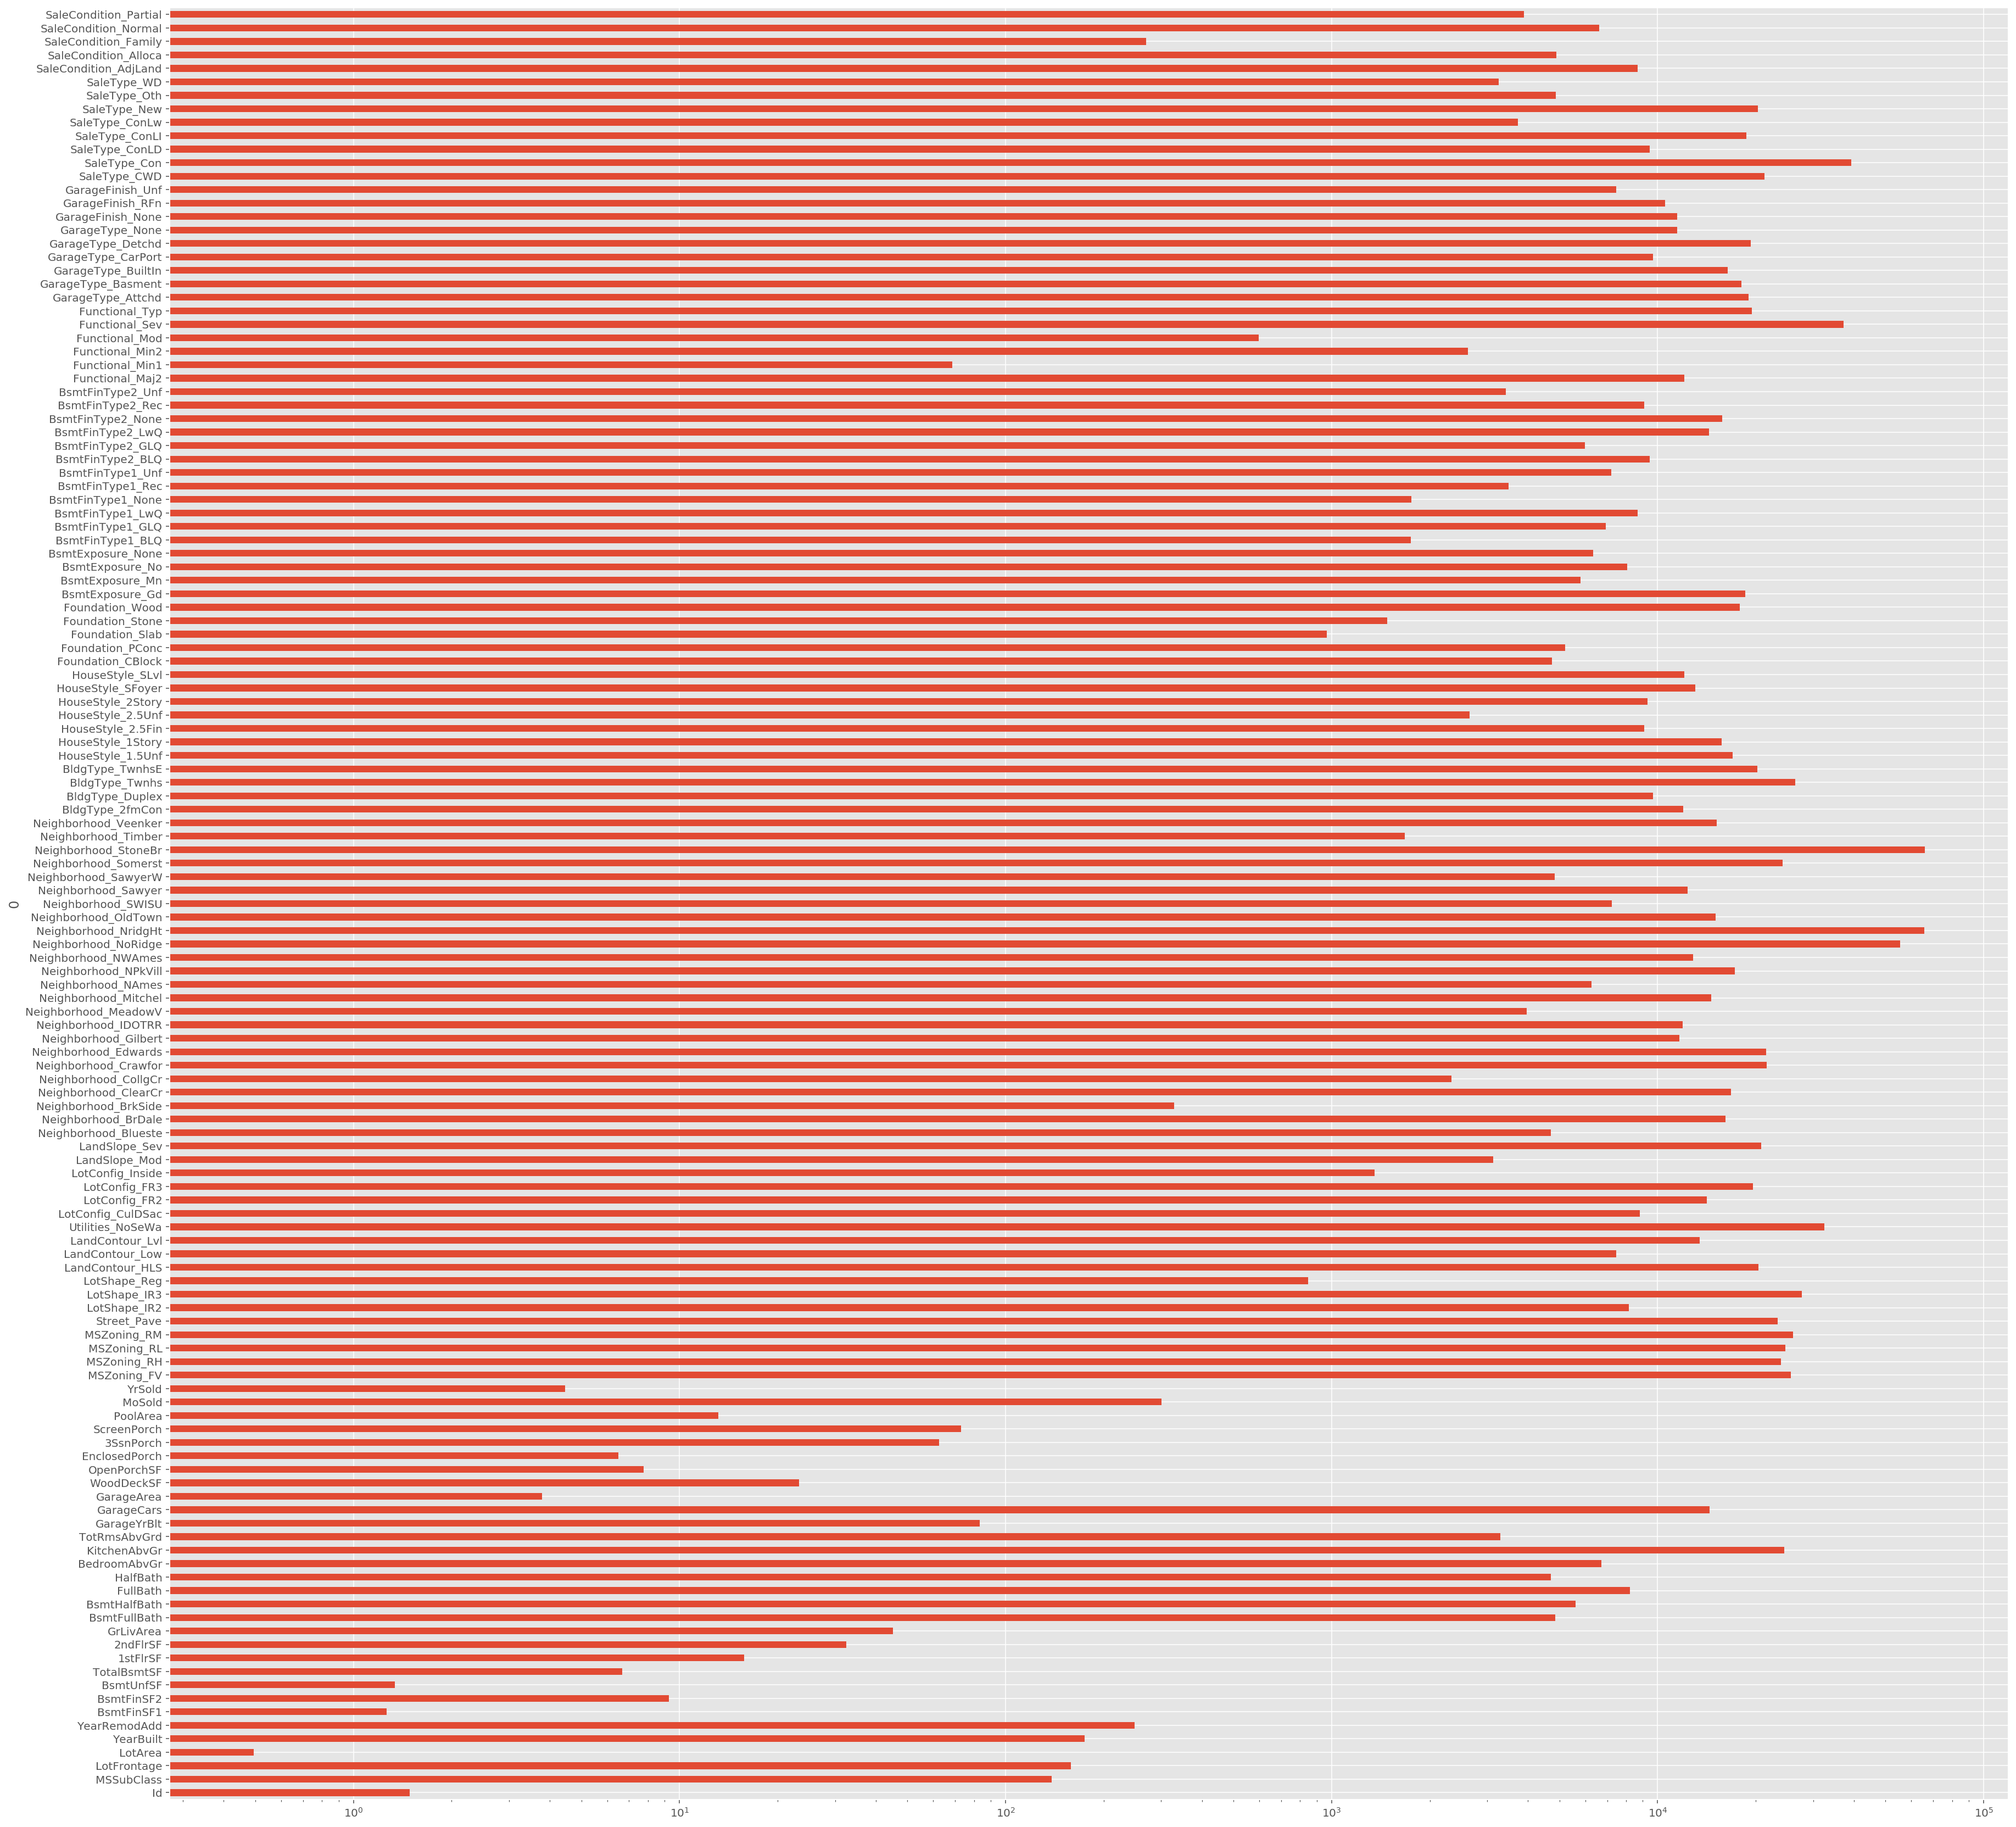

In [198]:
pd.DataFrame(list(zip(X_train.columns,np.abs(rcv_model.coef_)))).plot(kind='barh', x=0, y=1, figsize=(30, 30), legend=False)
plt.xscale('log')
plt.show()

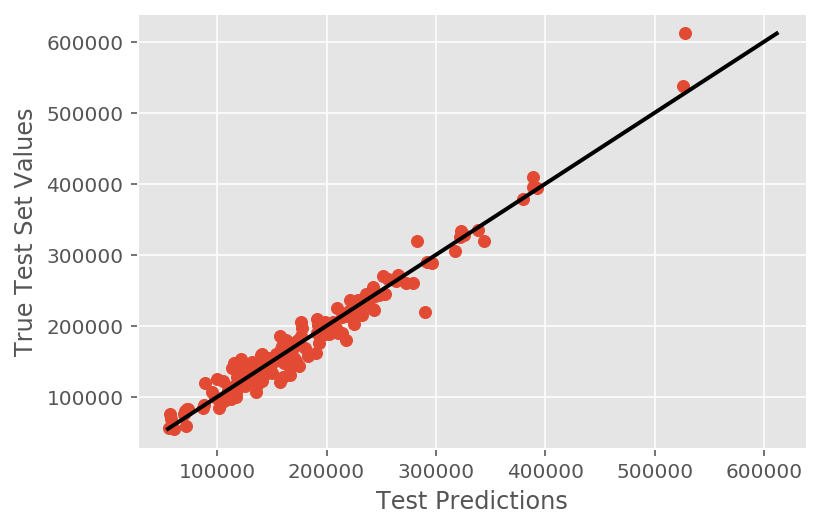

In [199]:
# The line / model on Test data
point_1 = [y_test.min(), y_test.max()]
plt.scatter(predictions_test, y_test)
plt.plot(point_1, point_1, c='k', lw=2)
plt.xlabel("Test Predictions")
plt.ylabel("True Test Set Values")
plt.show()

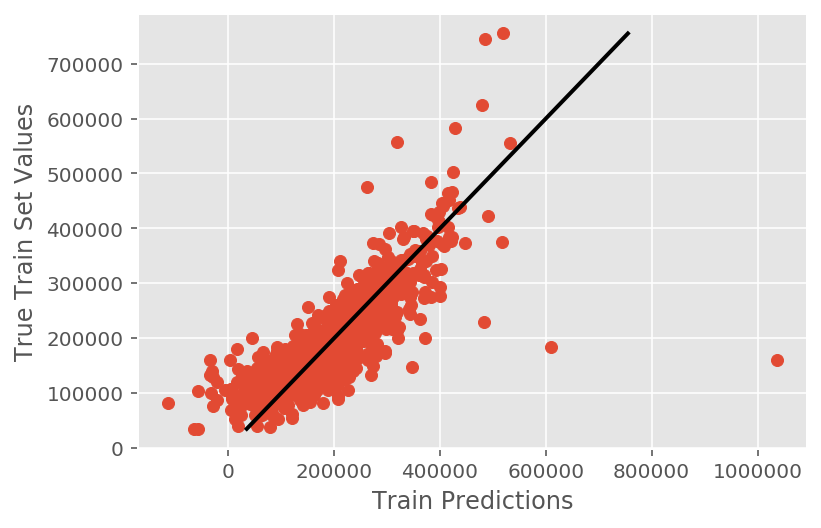

In [200]:
# The line / model on Train data
point_1 = [y_train.min(), y_train.max()]
plt.scatter(predictions_train, y_train)
plt.plot(point_1, point_1, c='k', lw=2)
plt.xlabel("Train Predictions")
plt.ylabel("True Train Set Values")
plt.show()

In [201]:
# The same with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores_shuffled = cross_val_score(lr_model, X_train, y_train, cv=kf)

print('Cross validation score:', cv_scores_shuffled)
print('Mean cross validation score:', cv_scores_shuffled.mean())

Cross validation score: [0.81039796 0.82757083 0.80867225 0.84574753 0.41453562]
Mean cross validation score: 0.741384838620432


In [202]:
print('Intercept:', r_model.intercept_)
pd.DataFrame(list(zip(X_test.columns,r_model.coef_)))

Intercept: -712255.564348703


,0,1
0,Id,-1.485156
1,MSSubClass,-138.608358
2,LotFrontage,-158.312596
3,LotArea,0.493368
4,YearBuilt,174.958495
...,...,...
128,SaleCondition_AdjLand,8678.180990
129,SaleCondition_Alloca,4891.270737
130,SaleCondition_Family,-269.542946
131,SaleCondition_Normal,6625.429021


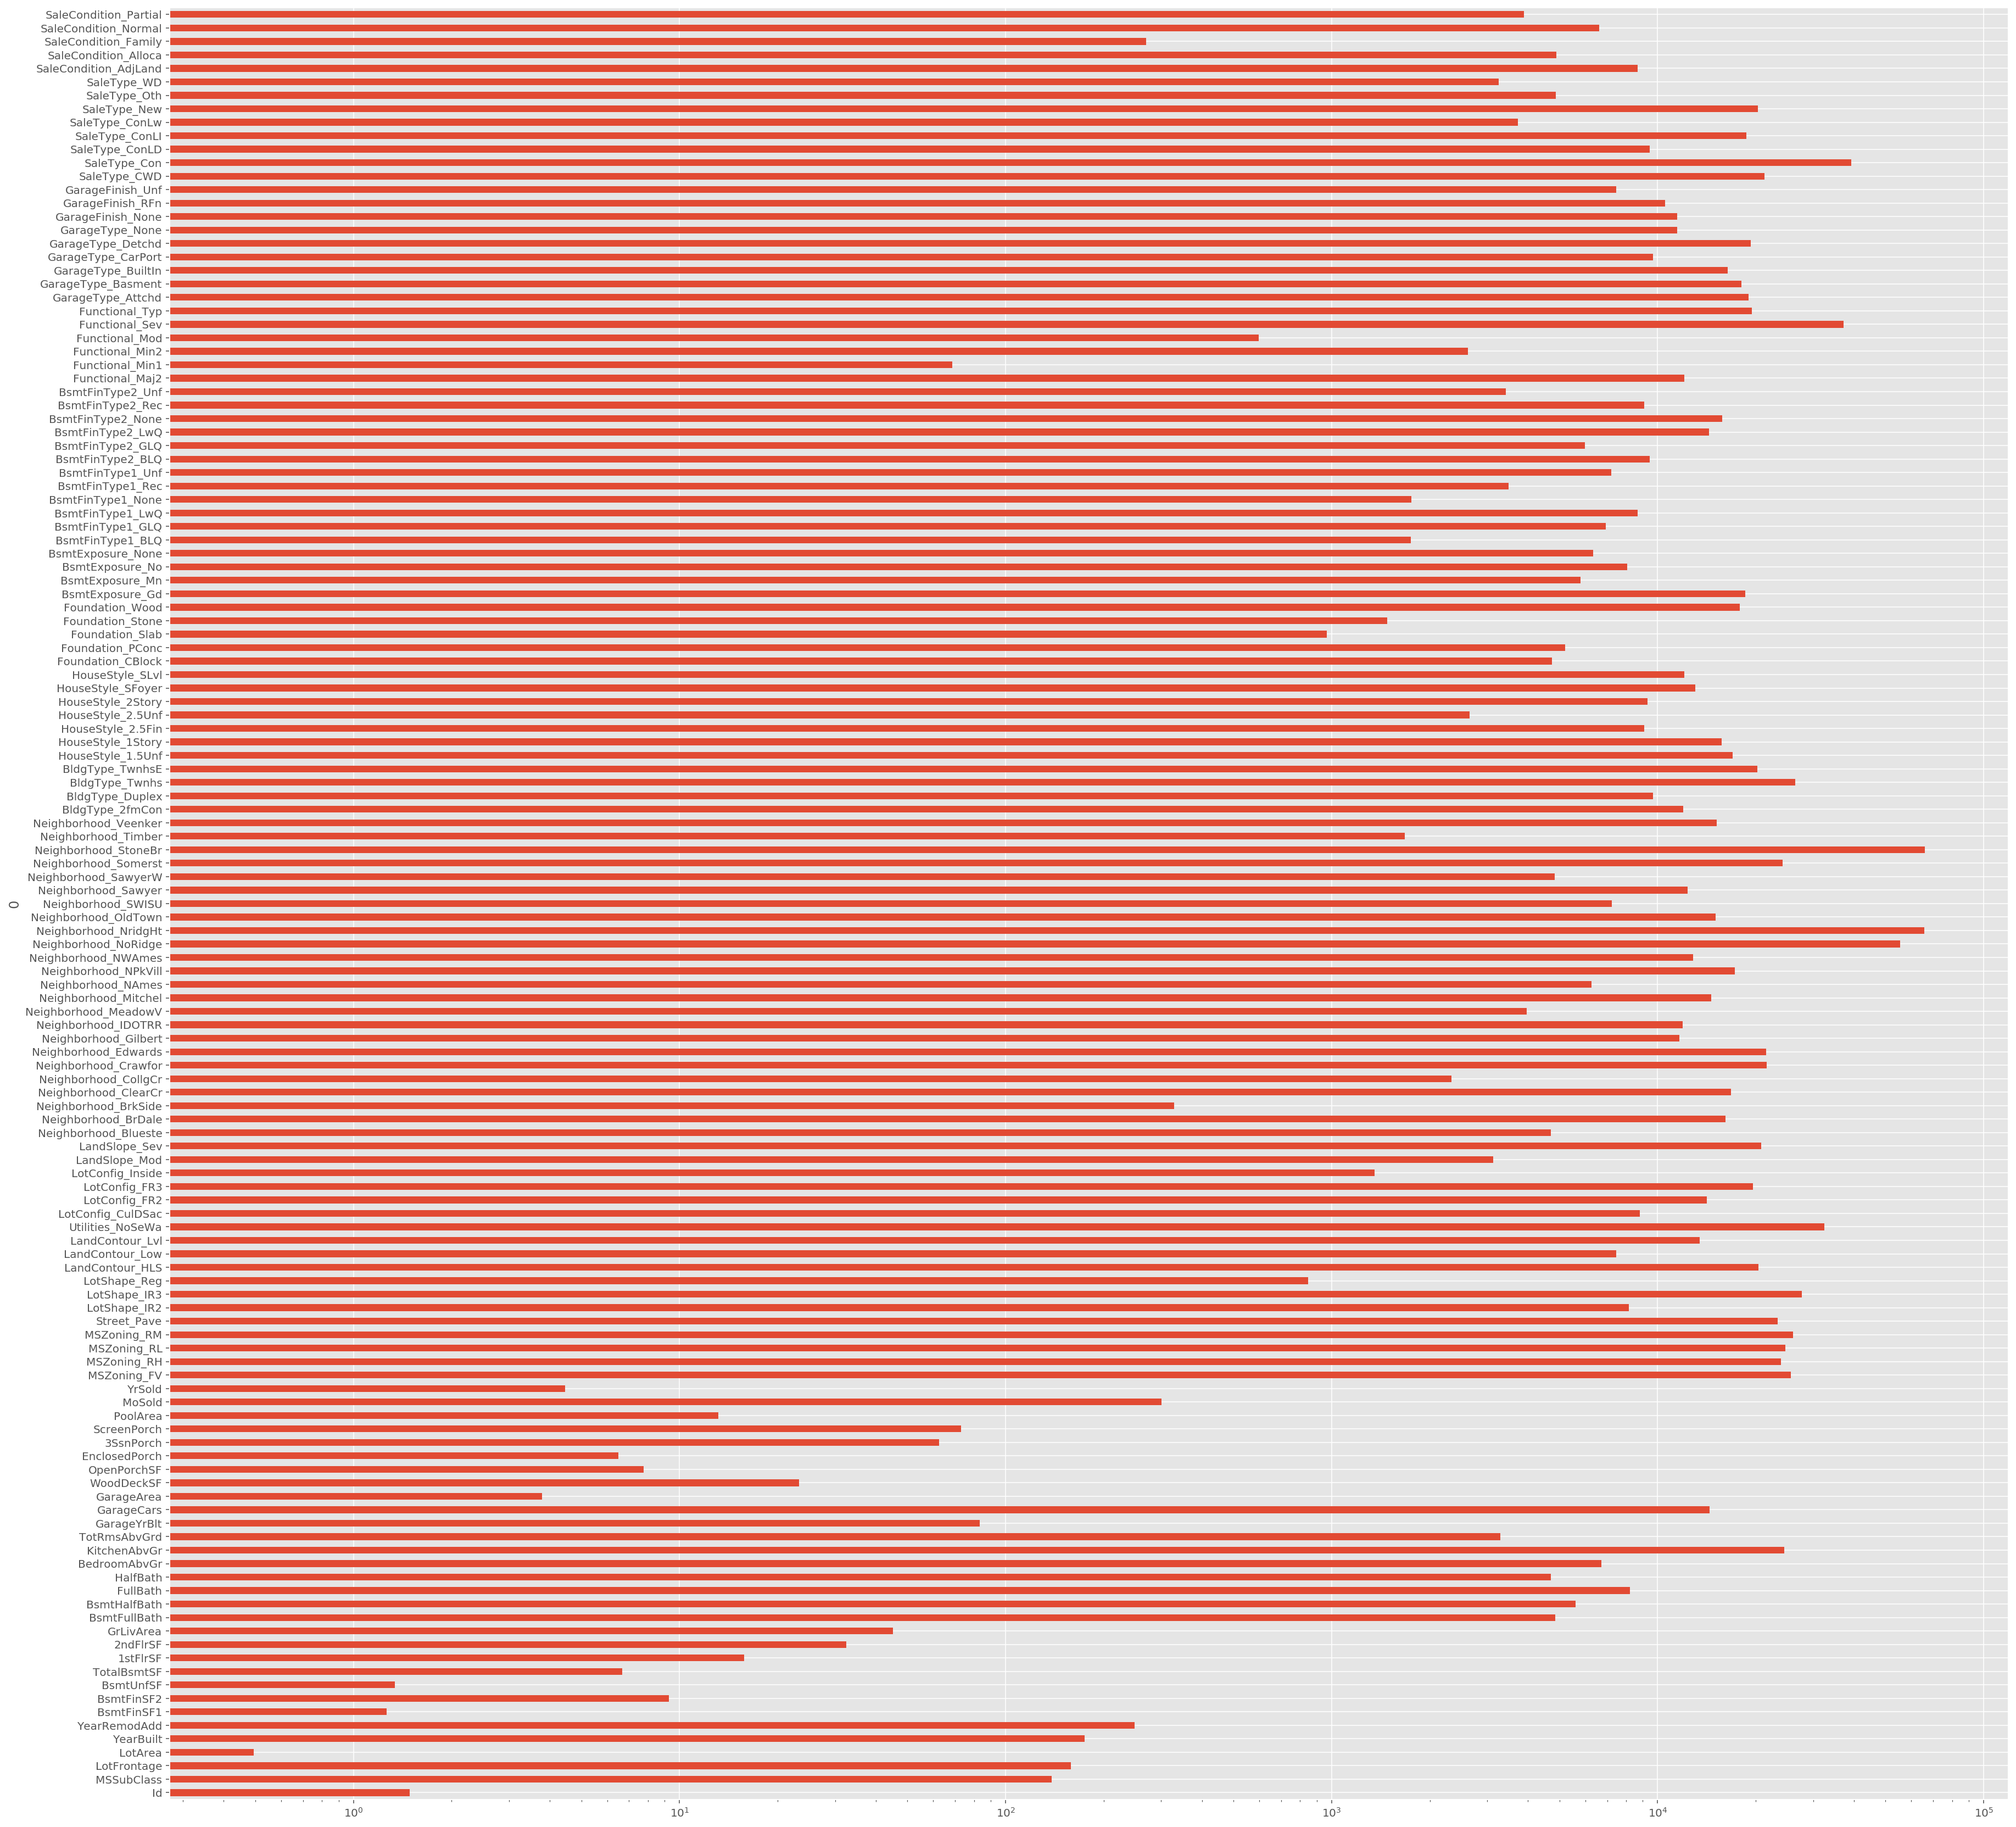

In [203]:
pd.DataFrame(list(zip(X_test.columns,np.abs(r_model.coef_)))).plot(kind='barh', x=0, y=1, figsize=(30, 30), legend=False)
plt.xscale('log')
plt.show()

In [204]:

# create a Ridge model instance
model = Ridge(alpha=alpha)
    
# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
# print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
print("Std for cross-validated training:", scores.std())
# fit and evaluate the data on the whole training set
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

Mean cross-validated training score: 0.7915614964670408
Std for cross-validated training: 0.06855734231745048
Training Score: 0.8583816692834021
Test Score: 0.8664729993659782


In [205]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                          columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef[df_coef['coef_abs'] > 0].sort_values(by='coef_abs', ascending=False)

,coefficients,coef_abs
Neighborhood_StoneBr,66051.042403,66051.042403
Neighborhood_NridgHt,65698.506907,65698.506907
Neighborhood_NoRidge,55369.314760,55369.314760
SaleType_Con,39258.086603,39258.086603
Functional_Sev,-37141.452053,37141.452053
...,...,...
GarageArea,-3.787638,3.787638
Id,-1.485156,1.485156
BsmtUnfSF,-1.339299,1.339299
BsmtFinSF1,-1.261487,1.261487


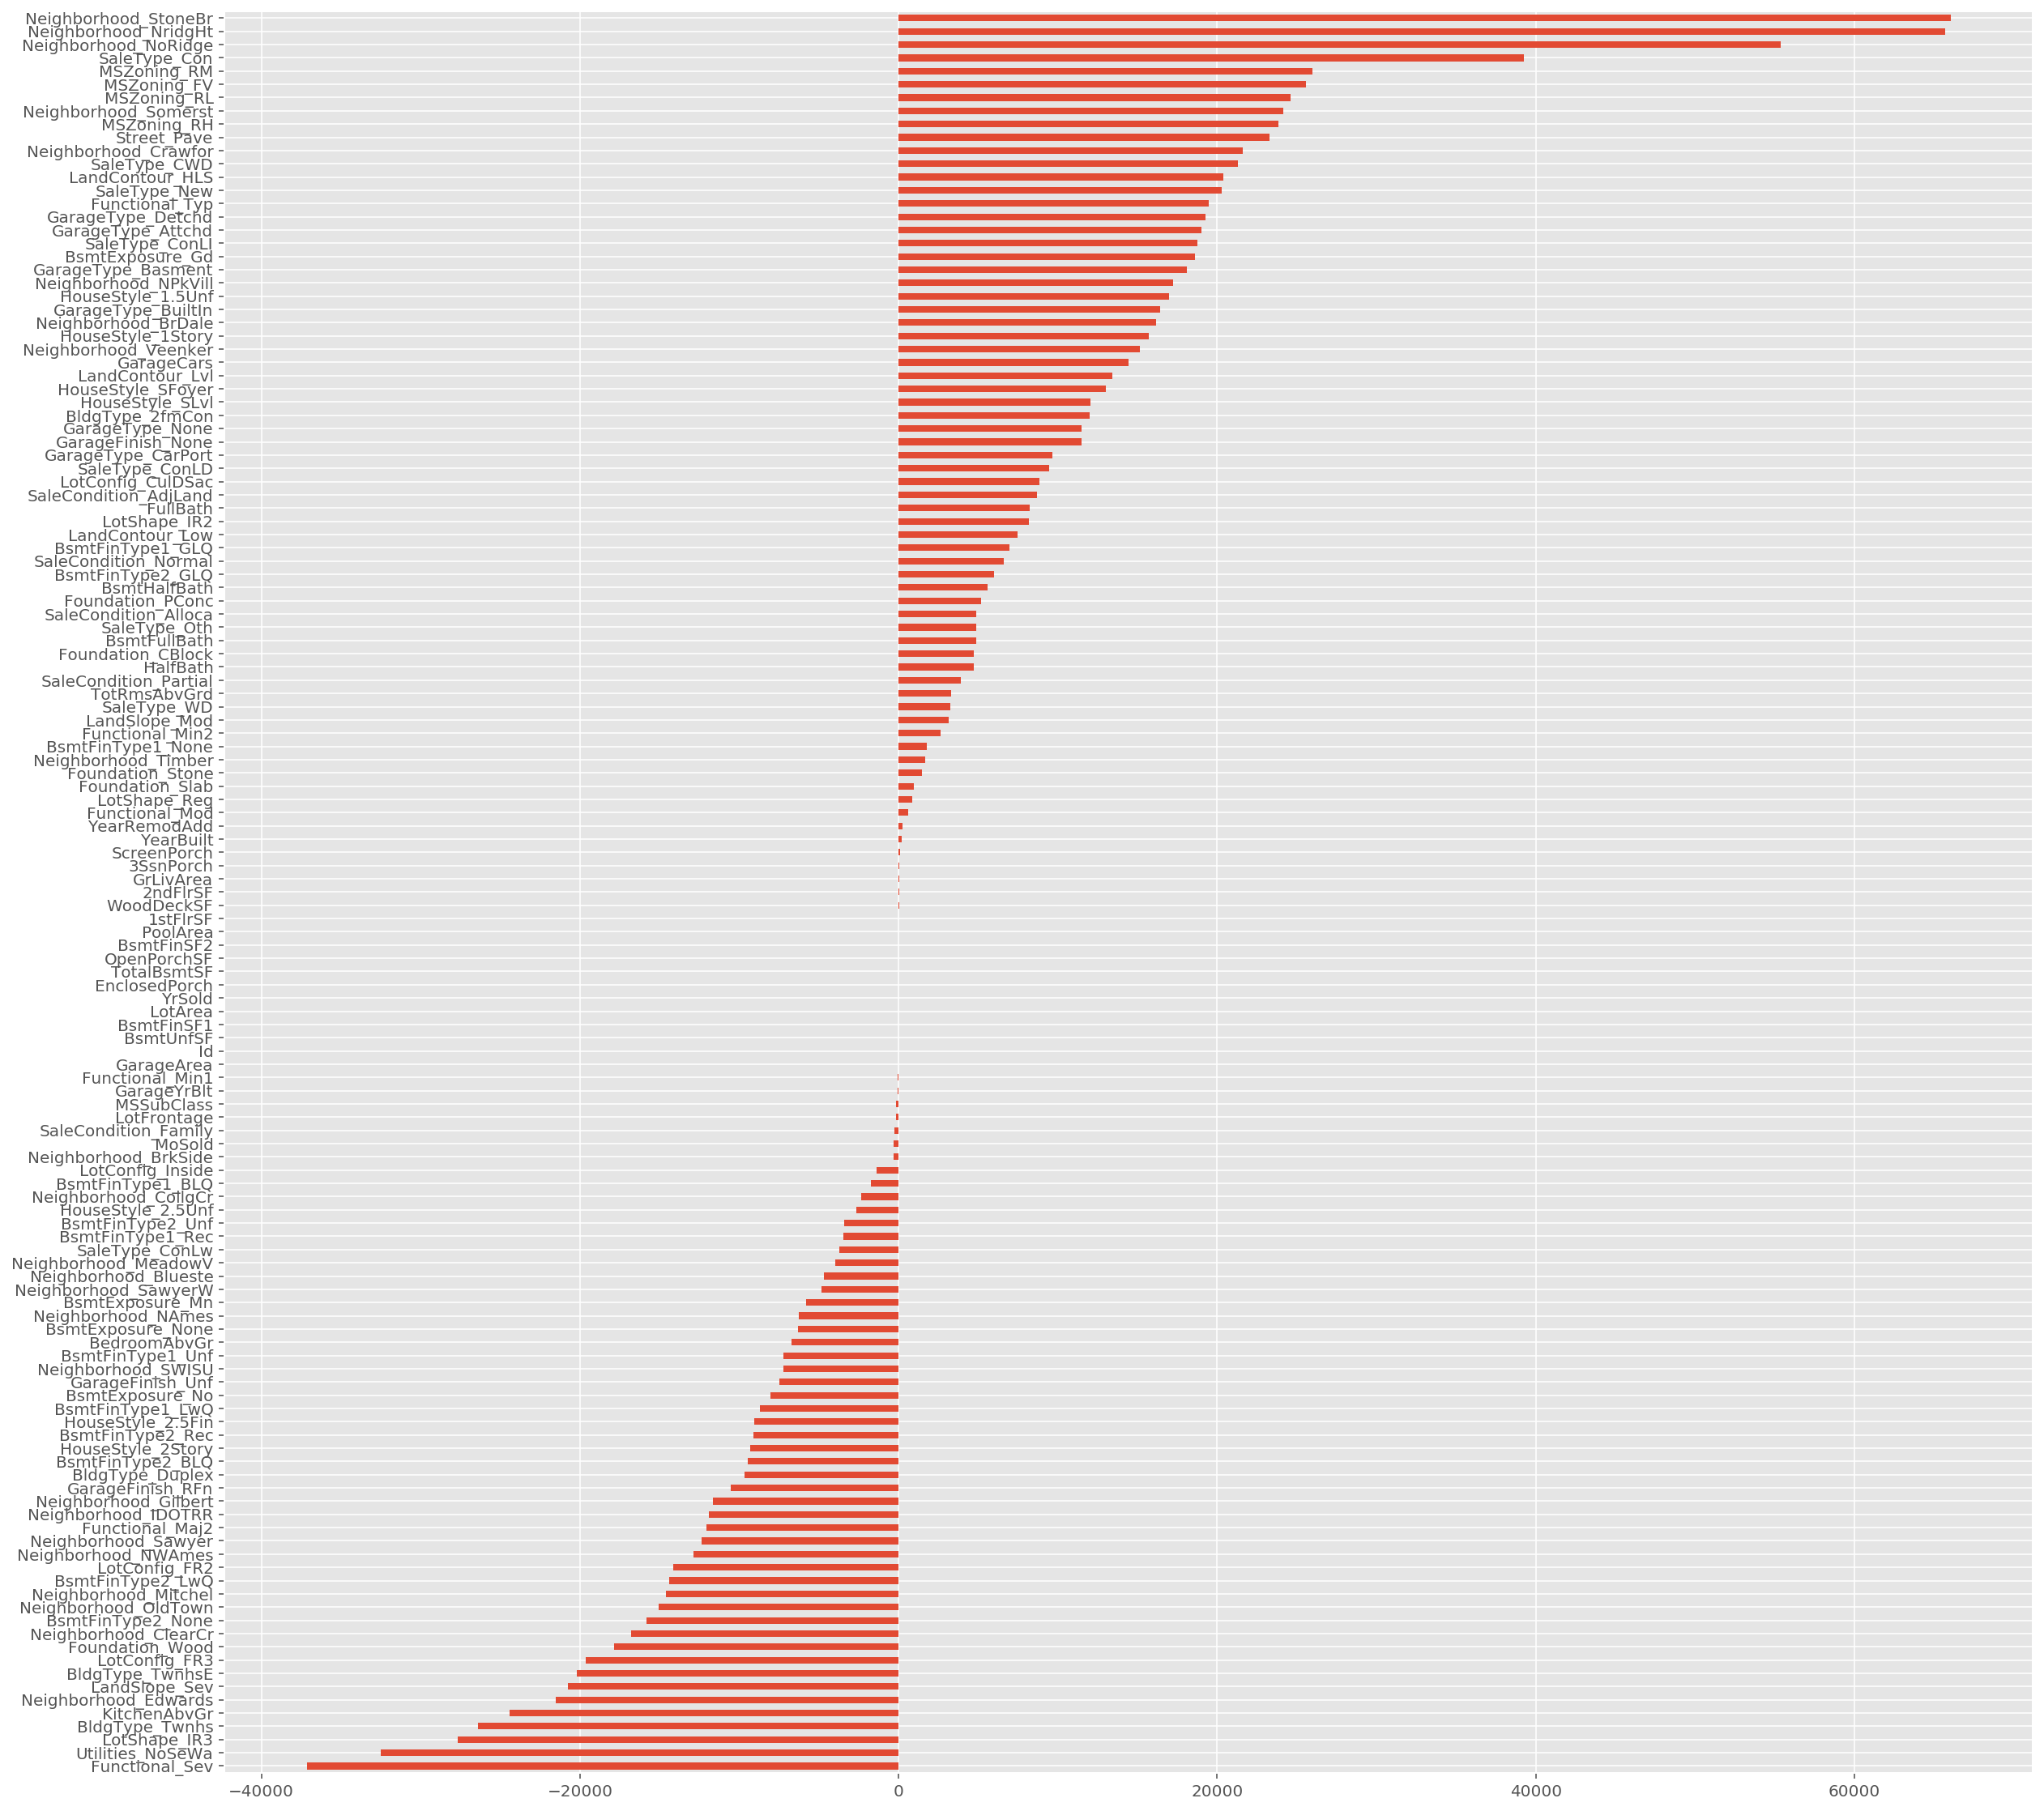

In [176]:
# plot the magnitude of the coefficients
df_coef[df_coef['coef_abs'] > 0]['coefficients'].sort_values().plot(kind='barh', figsize=(20,20));

In [177]:
from sklearn.linear_model import Lasso

In [178]:
# model = LassoCV(alphas=np.logspace(-4, 4, 1000), cv=5) # logspace to get rough area of optimal al
model = LassoCV(alphas=np.linspace(0.02, 0.04, 1000), cv=5) # linespace to hone in on th optimal alpha with greater accruracy\n",
# fit the model
model.fit(X_train, y_train)
# get the best alpha\n",
print('Best alpha:', model.alpha_)
# evaluate on the training set\n",
print('Training score:', model.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", model.score(X_test, y_test))

/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486291612444.6982, tolerance: 660870637.9888386
  tol, rng, random, positive)
/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 485907168355.75415, tolerance: 660870637.9888386
  tol, rng, random, positive)
/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481431832226.19775, tolerance: 660870637.9888386
  tol, rng, random, positive)
/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/skl

Best alpha: 0.04
Training score: 0.8588012663092747
Test Score: 0.8625034925552881


/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570356009983.2549, tolerance: 807923810.4946994
  positive)


In [208]:
# create a Lasso model instance
la_model = Lasso(alpha=alpha)
    
# get cross validated scores
scores = cross_val_score(la_model, X_train, y_train, cv=5)
# print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
print("Std for cross-validated training:", scores.std())
# fit and evaluate the data on the whole training set
la_model.fit(X_train, y_train)
print("Training Score:", la_model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", la_model.score(X_test, y_test))

/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486784277017.054, tolerance: 660870637.9888386
  positive)
/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 419650098805.0559, tolerance: 631165692.4141443
  positive)
/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433965150903.0401, tolerance: 608607184.9787138
  positive)


Mean cross-validated training score: 0.7869301625023754
Std for cross-validated training: 0.06634277096343606
Training Score: 0.85879936089137
Test Score: 0.862665170925051


/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484110364443.189, tolerance: 696170398.5338953
  positive)
/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351951564857.767, tolerance: 633860745.3734549
  positive)
/Users/monicasandramensah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569954813832.7256, tolerance: 807923810.4946994
  positive)


In [209]:
print('Intercept:', la_model.intercept_)
pd.DataFrame(list(zip(X_train.columns,la_model.coef_)))

Intercept: -727005.2334157238


,0,1
0,Id,-1.495219
1,MSSubClass,-130.657656
2,LotFrontage,-162.616172
3,LotArea,0.504166
4,YearBuilt,172.452623
...,...,...
128,SaleCondition_AdjLand,9264.856026
129,SaleCondition_Alloca,4416.869092
130,SaleCondition_Family,-284.636035
131,SaleCondition_Normal,5906.370373


In [211]:
y_pred_lasso = model.predict(X_train)

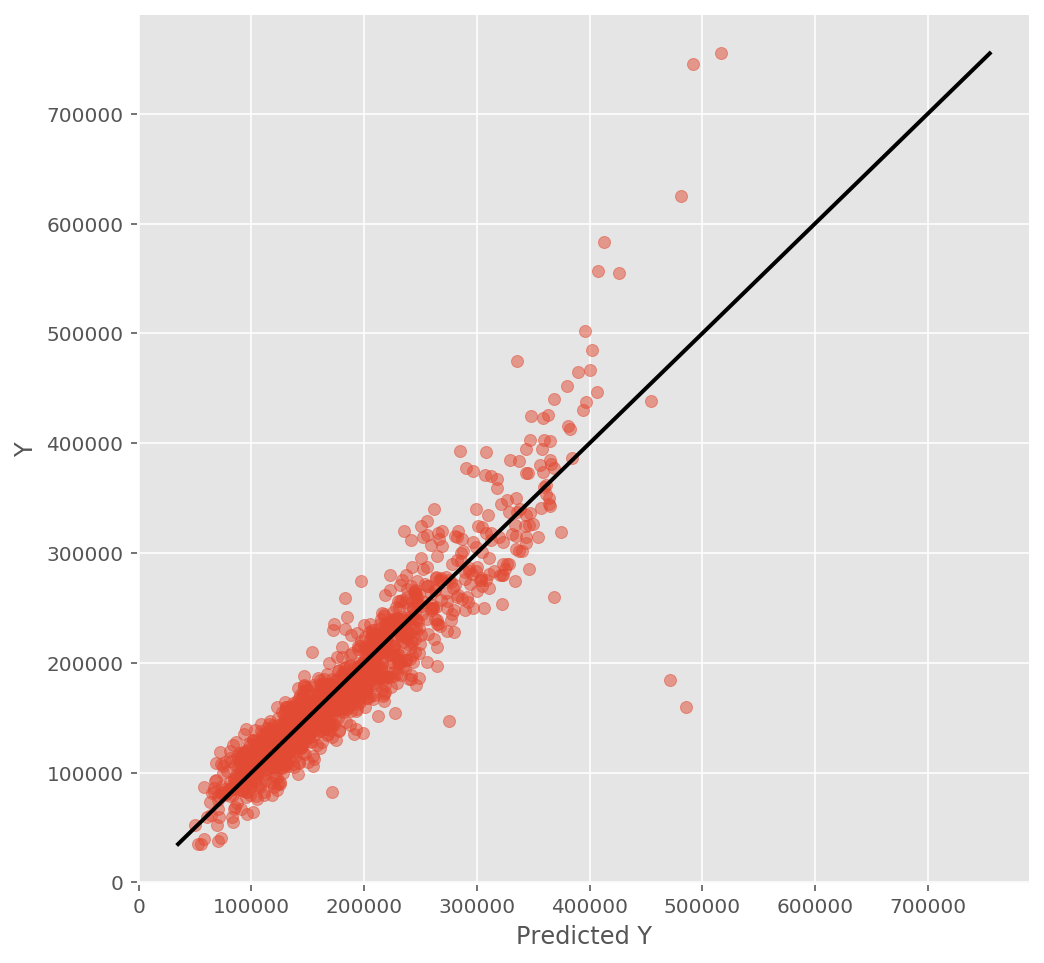

In [212]:
fig, ax = plt.subplots(figsize=(8, 8))
   
ax.scatter(x=y_pred_lasso, y=y_train, alpha=0.5)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='k', lw=2)
ax.set_ylabel('Y')
ax.set_xlabel('Predicted Y')
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

The intercept analysis above provides the effect on renovatable features in dollars.
At zero using the lasso a property would be valued at £727,005. For the linear regression models the value at zeron was £712,255 therefore the lasso model appears to be more favourble when prediciting values. From the numbers it looks like family homes could give them a higher return on their investment as they have a lower cost at zero  than the others.


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: Features that predict an Abnorml 